# Agentic RAG
智能体检索增强生成（Agentic RAG）结合了检索增强生成和基于智能体的推理的优势。它并非在回答前先检索文档，而是由一个（由大语言模型驱动的）智能体逐步推理，并在交互过程中决定何时以及如何检索信息。  
要让智能体具备检索增强生成（RAG）功能，唯一需要的就是让它能够使用一种或多种工具来获取外部知识，例如文档加载器、Web API或数据库查询工具。  
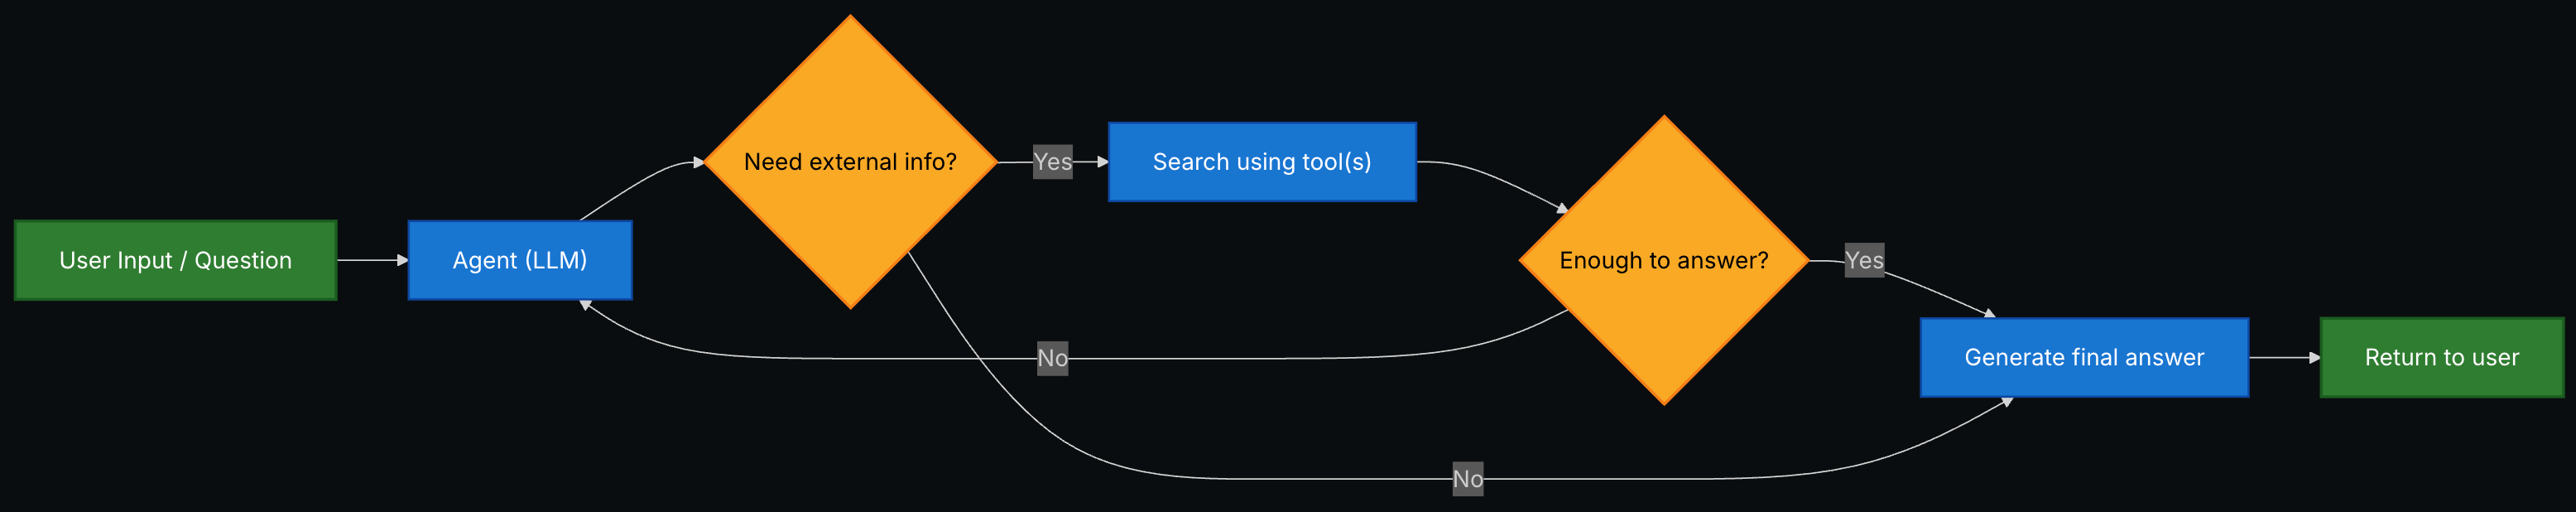

## 简单示例

## 简单示例（可运行）

In [1]:
import requests
from langchain.agents import create_agent
from langchain.tools import tool
from langchain_core.messages import HumanMessage
from markdownify import markdownify

ALLOWED_DOMAINS = ["https://langchain-ai.github.io/"]
LLMS_TXT = 'https://langchain-ai.github.io/langgraph/llms.txt'

# @tool
# def fetch_documentation(url: str) -> str:
#     """从URL获取内容并转换为文档"""
#     if not any(url.startswith(domain) for domain in ALLOWED_DOMAINS):
#         return f"Error: URL 不被允许。必须是以这些中的一个作为URL的开始: {', '.join(ALLOWED_DOMAINS)}"
#     response = requests.get(url, 
#                             timeout=10.0,
#                             # export all_proxy=http://127.0.0.1:7890
#                             # export https_proxy=http://127.0.0.1:7897 http_proxy=http://127.0.0.1:7897 all_proxy=socks5://127.0.0.1:7897
#                             proxies={
#                                 "all_proxy": "socks5://127.0.0.1:7897",
#                                 "https_proxy": "http://127.0.0.1:7897",
#                                 "http_proxy": "http://127.0.0.1:7897"
#                                 },
#                             )
#     response.raise_for_status()
#     md_str = markdownify(response.text)
#     print("fetch_documentation->:")
#     print(f'url={url}')
#     print(f'markdown document:\n{md_str}')
    
#     return md_str


from langchain_community.document_loaders import WebBaseLoader

@tool
def fetch_documentation(url: str) -> str:
    """从URL获取内容并转换为文档"""
    if not any(url.startswith(domain) for domain in ALLOWED_DOMAINS):
        return f"Error: URL 不被允许。必须是以这些中的一个作为URL的开始: {', '.join(ALLOWED_DOMAINS)}"
    
    doc = WebBaseLoader(url).load()[0]
    title = doc.metadata["title"]
    content = doc.page_content
    
    md_str = markdownify(f"# {title}\n\n{content}")
    print("fetch_documentation->:")
    print(f'url={url}')
    print(f'markdown document:\n{md_str}')
    
    return md_str

llms_txt_content = requests.get(LLMS_TXT).text
print(llms_txt_content)

USER_AGENT environment variable not set, consider setting it to identify your requests.



# Guides

- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/index/): This page provides an overview of the LangGraph project, including its logo and essential scripts for functionality within MkDocs. It also includes a reference to the README.md file for detailed information about the project. The content is designed to be user-friendly and visually appealing.
- [LangGraph Quickstart Guide](https://langchain-ai.github.io/langgraph/agents/agents/): This quickstart guide provides step-by-step instructions for setting up and using LangGraph's prebuilt components to create agentic systems. It covers prerequisites, installation, agent creation, configuration of language models, and advanced features like memory and structured output. Ideal for developers looking to leverage LangGraph for building intelligent agents.
- [Getting Started with LangGraph: Building AI Agents](https://langchain-ai.github.io/langgraph/concepts/why-langgraph/): This page provides an overview of L

In [2]:
import time
from typing import Any, Dict, Optional
from langchain.agents.middleware import AgentMiddleware
from langchain_core.runnables import RunnableConfig

# 定义一个简单的速率限制中间件
class RateLimitMiddleware(AgentMiddleware):
    """
    在每次 LLM 节点调用后添加延时的中间件。
    """
    def __init__(self, delay_seconds: float = 1.0, node_name: str = "agent"):
        self.delay_seconds = delay_seconds
        self.node_name = node_name  # LLM 节点的默认名称是 "agent"

    def post_node(self, 
                  node_name: str, 
                  inputs: Dict[str, Any], 
                  output: Optional[Dict[str, Any]], 
                  config: Optional[RunnableConfig] = None) -> Optional[Dict[str, Any]]:
        """
        在节点执行后调用。
        """
        print(f"node_name={node_name} self.node_name={self.node_name}")
        print(f"inputs={inputs}")
        print(f"output={output}")
        print(f"config={config}")
        # 仅当执行的是 LLM 节点时才添加延迟
        if node_name == self.node_name:
            print(f"RateLimitMiddleware: Sleeping for {self.delay_seconds}s after calling LLM...")
            time.sleep(self.delay_seconds)
        # 必须返回 output，否则会中断执行链
        return output

In [3]:
system_prompt = f"""你是一名专业的Python开发者和技术助手。
你的主要职责是帮助用户解决有关LangGraph及相关工具的问题。

说明：
1. 如果用户提出的问题你不确定，或者该问题可能涉及API的使用、行为或配置，你必须使用`fetch_documentation`工具查阅相关文档。
2. 引用文档时，要清晰总结并包含内容中的相关上下文。
3. 不得使用允许域名之外的任何URL。
4. 如果文档获取失败，需告知用户，并凭借你最专业的理解继续作答。

你可以从以下经批准的来源访问官方文档：
{llms_txt_content}

在回答用户关于LangGraph的问题之前，你必须查阅文档以获取最新资料。
你的回答应清晰、简洁且技术准确。"""

tools = [fetch_documentation]

from utils import llm_modelscope
model = llm_modelscope(model="Qwen/Qwen3-30B-A3B-Thinking-2507")

agent = create_agent(
    model=model,
    tools=tools,
    system_prompt=system_prompt,
    middleware=[
        RateLimitMiddleware(
            delay_seconds=5,
            node_name="Agentic RAG",
        ),
    ],
    name="Agentic RAG",
)

response = agent.invoke({
    "messages": [
        HumanMessage(content="编写一个使用预构建的create react agent的langgraph智能体的简短示例。该智能体应该能够查询股票价格信息。")
    ]
})

response

fetch_documentation->:
url=https://langchain-ai.github.io/langgraph/agents/run_agents/
markdown document:
# Redirecting...
Redirecting...
Redirecting...
fetch_documentation->:
url=https://langchain-ai.github.io/langgraph/agents/tools/
markdown document:
# Redirecting...
Redirecting...
Redirecting...


{'messages': [HumanMessage(content='编写一个使用预构建的create react agent的langgraph智能体的简短示例。该智能体应该能够查询股票价格信息。', additional_kwargs={}, response_metadata={}, id='13915465-9739-4d94-b9e4-766c8243967b'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 532, 'prompt_tokens': 13492, 'total_tokens': 14024, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_provider': 'openai', 'model_name': 'Qwen/Qwen3-30B-A3B-Thinking-2507', 'system_fingerprint': '', 'id': 'chatcmpl-4ea86377-6eda-48d6-bd94-cf579841f376', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--3fd722d3-c3f7-4fc6-a763-2f7a6bf4c3ea-0', tool_calls=[{'name': 'fetch_documentation', 'args': {'url': 'https://langchain-ai.github.io/langgraph/agents/run_agents/'}, 'id': 'call_82b4db12c4d048c9b0de67', 'type': 'tool_call'}], usage_metadata={'input_tokens': 13492, 'output_tokens': 532, 'total_tokens': 14024, 'input_token_details': {}, 'output_token_de

In [4]:
for msg in response["messages"]:
    msg.pretty_print()

================================ Human Message =================================

编写一个使用预构建的create react agent的langgraph智能体的简短示例。该智能体应该能够查询股票价格信息。
================================== Ai Message ==================================
Tool Calls:
  fetch_documentation (call_82b4db12c4d048c9b0de67)
 Call ID: call_82b4db12c4d048c9b0de67
  Args:
    url: https://langchain-ai.github.io/langgraph/agents/run_agents/
================================= Tool Message =================================
Name: fetch_documentation

# Redirecting...
Redirecting...
Redirecting...
================================== Ai Message ==================================
Tool Calls:
  fetch_documentation (call_1783a11d1fa746ab8c7302)
 Call ID: call_1783a11d1fa746ab8c7302
  Args:
    url: https://langchain-ai.github.io/langgraph/agents/tools/
================================= Tool Message =================================
Name: fetch_documentation

# Redirecting...
Redirecting...
Redirecting...
============================

In [6]:
url = "https://docs.langchain.com/oss/python/langgraph/quickstart"
# https://langchain-ai.github.io/langgraph/agents/run_agents/ 此网址会被重定向
doc = WebBaseLoader(url).load()[0]
title = doc.metadata["title"]
content = doc.page_content

md_str = markdownify(f"# {title}\n\n{content}")
print(md_str)

# Quickstart - Docs by LangChain
Quickstart - Docs by LangChainSkip to main content🚀 Share how you're building agents for a chance to win LangChain swag!Docs by LangChain home pageLangChain + LangGraphSearch...⌘KAsk AIGitHubTry LangSmithTry LangSmithSearch...NavigationGet startedQuickstartLangChainLangGraphDeep AgentsIntegrationsLearnReferenceContributePythonOverviewLangGraph v1.0Release notesMigration guideGet startedInstallQuickstartLocal serverThinking in LangGraphWorkflows + agentsCapabilitiesPersistenceDurable executionStreamingInterruptsTime travelMemorySubgraphsProductionApplication structureTestLangSmith StudioAgent Chat UILangSmith DeploymentLangSmith ObservabilityLangGraph APIsGraph APIFunctional APIRuntimeGet startedQuickstartCopy pageCopy pageThis quickstart demonstrates how to build a calculator agent using the LangGraph Graph API or the Functional API.
Use the Graph API if you prefer to define your agent as a graph of nodes and edges.
Use the Functional API if you prefer 